

## Valuación Estocástica y Análisis de Sensibilidad ($SPOT)

Análisis fundamental + ciencia de datos. A diferencia de nuestro análisis previo con **Snowflake**, donde proyectamos el futuro basándonos en la aceleración del *Revenue*, aquí utilizamos la **volatilidad histórica del flujo de caja** para construir un mapa de probabilidades más robusto y menos subjetivo.

---

## 1. De Proyecciones a Persistencia: FCF vs. Revenue

La base de nuestra valuación es el **Free Cash Flow (FCF)**. Mientras que en empresas *Early Growth* (como Snowflake) el ingreso es el indicador líder, en empresas que ya escalan márgenes (como Spotify), el FCF es la métrica definitiva de valor.

### Correcciones Técnicas de Integridad

Para asegurar que los datos de entrada sean fiables, el motor aplica:

* **Normalización de Signos:** Corrección automática del **Capital Expenditure** para garantizar que se reste del flujo operativo.
* **Estabilidad del CAGR:** Lógica de control para evitar errores de indeterminación () en el cálculo de la tasa de crecimiento anual compuesta:

$$CAGR = \left(\frac{V_{final}}{V_{initial}}\right)^{\frac{1}{t}} - 1$$

---

## 2. Simulación de Monte Carlo: Volatilidad Empírica

En el video pasado utilizamos distribuciones triangulares basadas en estimaciones del analista, utilizamos la **volatilidad histórica real** del FCF de Spotify ($\sigma$).

Proyectamos los próximos cuatro trimestres mediante la fórmula de transición estocástica:
$$FCF_{i, t+1} = FCF_{i, t} \times (1 + \mu + \sigma \epsilon)$$

Donde:

* $\mu$: Media de los retornos históricos del FCF.
* $\sigma$: Desviación estándar (volatilidad) de los flujos.
* $\epsilon$: Choque aleatorio derivado de una distribución normal estándar $N(0, 1)$.

---

## 3. Matriz de Sensibilidad y "Market Location"

Recuperamos y mejoramos las herramientas de nuestro análisis anterior para responder: **¿Dónde está parado el mercado hoy?**

1. **Matriz de Sensibilidad (Heatmap):** Visualiza el Precio Objetivo bajo diferentes combinaciones de **WACC** y **Múltiplos de Salida ($P/FCF$)**.

$$PV = \frac{FCF_{proyectado} \times \text{Múltiplo}}{(1 + WACC)^n}$$

2. **Ubicación del Mercado (Percentiles):** Determinamos en qué percentil de nuestra simulación se encuentra el precio actual.
> **Nota:** Si el precio de mercado cotiza en el $P_{90}$, significa que solo se justifica en el 10% de nuestros escenarios más optimistas.


---

## 4. Análisis de Sensibilidad de Spearman (Tornado Chart)

Aplicamos correlaciones de **Spearman** para identificar las "palancas de valor". Este análisis nos permite aislar qué variable impacta con mayor fuerza en el precio final:

* **Crecimiento de FCF:** El motor interno del negocio.
* **WACC:** El impacto de las tasas de interés y el riesgo macro.
* **Múltiplo:** El sentimiento y la narrativa del mercado.

---

## 5. Objetivo: El Margen de Seguridad

El resultado no es un precio "objetivo" único, sino un **Mapa de Probabilidades**. Buscamos activos donde el precio actual de mercado se encuentre en la zona de percentiles bajos ($P_{10}$ a $P_{40}$) de nuestra distribución, lo que indicaría un **Margen de Seguridad** estadísticamente significativo.




In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración de estilo
sns.set_palette("viridis")

In [6]:
class QuantmentalProAnalyzer:
    def __init__(self, ticker):
        self.ticker = ticker
        self.stock = yf.Ticker(ticker)
        self.info = self.stock.info
        self.fcf_df = pd.DataFrame()
        
    def get_financial_data(self):
        """Descarga y limpia los datos financieros."""
        print(f"\n{'='*70}")
        print(f"🔍 EXTRACCIÓN DE DATOS: {self.ticker}")
        print(f"{'='*70}")
        
        qtr_cf = self.stock.quarterly_cashflow
        if qtr_cf.empty:
            print("❌ No se pudieron obtener los flujos de caja.")
            return False
            
        qtr_cf.columns = pd.to_datetime(qtr_cf.columns)
        fcf_data = []
        
        # Cálculo de FCF corrigiendo signos y NaNs
        for date in qtr_cf.columns:
            ocf = qtr_cf.loc['Operating Cash Flow', date] if 'Operating Cash Flow' in qtr_cf.index else 0
            capex = qtr_cf.loc['Capital Expenditure', date] if 'Capital Expenditure' in qtr_cf.index else 0
            fcf = (ocf - abs(capex)) / 1e6 # En millones
            fcf_data.append({'Date': date, 'FCF': fcf})
            
        self.fcf_df = pd.DataFrame(fcf_data).sort_values('Date').dropna()
        print(f"✅ Datos de {len(self.fcf_df)} trimestres procesados con éxito.")
        return True

    def plot_historical_fcf(self):
        """Gráfico 1: Análisis Histórico de Generación de Caja."""
        print(f"\n📊 ANALIZANDO HISTÓRICO DE FREE CASH FLOW...")
        
        fcf_vals = self.fcf_df['FCF'].values
        first_val = fcf_vals[0]
        last_val = fcf_vals[-1]
        
        # Fix para el error de NaN que mencionaste
        if first_val != 0 and not np.isnan(first_val):
            total_change = ((last_val / first_val) - 1) * 100
            years = (self.fcf_df['Date'].iloc[-1] - self.fcf_df['Date'].iloc[0]).days / 365.25
            cagr = (pow(abs(last_val/first_val), 1/years)-1)*100 if years > 0 else 0
        else:
            total_change, cagr = 0, 0

        print(f" └─ FCF Inicial: ${first_val:.1f}M | FCF Actual: ${last_val:.1f}M")
        print(f" └─ Crecimiento Total: {total_change:+.1f}% | CAGR: {cagr:.1f}%")

        plt.figure(figsize=(12, 6))
        colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in self.fcf_df['FCF']]
        bars = plt.bar(range(len(self.fcf_df)), self.fcf_df['FCF'], color=colors, alpha=0.8)
        
        plt.title(f"{self.ticker} - Histórico Quarterly FCF\n(CAGR: {cagr:.1f}%)", fontsize=14, fontweight='bold')
        plt.xticks(range(len(self.fcf_df)), [d.strftime('%b %y') for d in self.fcf_df['Date']])
        plt.ylabel("Millions USD")
        plt.grid(axis='y', alpha=0.2)
        plt.show()

    def run_monte_carlo(self, simulations=1000):
        """Gráfico 2: Simulación de Monte Carlo para Proyección de FCF."""
        print(f"\n🎲 EJECUTANDO SIMULACIÓN DE MONTE CARLO (n={simulations})...")
        
        fcf_values = self.fcf_df['FCF'].values
        # Cálculo de retornos logarítmicos para mayor estabilidad quant
        returns = np.diff(fcf_values) / np.abs(fcf_values[:-1])
        returns = returns[~np.isnan(returns) & ~np.isinf(returns)]
        
        mu, sigma = np.mean(returns), np.std(returns)
        print(f" └─ Volatilidad Trimestral del FCF: {sigma*100:.1f}%")
        
        sim_results = np.zeros((simulations, 4))
        last_fcf = fcf_values[-1]
        
        for i in range(simulations):
            curr = last_fcf
            for q in range(4):
                curr *= (1 + mu + sigma * np.random.normal())
                sim_results[i, q] = curr
                
        # Graficar proyección
        plt.figure(figsize=(12, 6))
        median_sim = np.median(sim_results, axis=0)
        p10, p90 = np.percentile(sim_results, 10, axis=0), np.percentile(sim_results, 90, axis=0)
        
        plt.plot(range(1, 5), median_sim, 'o-', color='#f1c40f', linewidth=3, label='Mediana Proyectada')
        plt.fill_between(range(1, 5), p10, p90, color='#f1c40f', alpha=0.2, label='Intervalo de Confianza (80%)')
        
        plt.title(f"Proyección Probabilística de FCF a 12 Meses", fontsize=14)
        plt.xlabel("Trimestres Adelante")
        plt.ylabel("FCF Proyectado (Millions USD)")
        plt.legend()
        plt.show()
        
        return sim_results

    def plot_sensitivity_analysis(self, sim_results):
        """Gráfico 3: Matriz de Sensibilidad (Heatmap) de Valuación."""
        print(f"\n🌡️ GENERANDO MATRIZ DE SENSIBILIDAD (WACC vs Múltiplos)...")
        
        # Parámetros base
        wacc_range = np.linspace(0.08, 0.12, 5) # 8% a 12%
        exit_multiples = np.linspace(20, 40, 5) # Múltiplos P/FCF
        
        fcf_proyectado_anual = np.median(np.sum(sim_results, axis=1))
        shares = self.info.get('sharesOutstanding', 1)
        
        sensitivity_matrix = np.zeros((len(wacc_range), len(exit_multiples)))
        
        for i, wacc in enumerate(wacc_range):
            for j, mult in enumerate(exit_multiples):
                terminal_value = fcf_proyectado_anual * mult
                present_value = terminal_value / (1 + wacc)
                price_per_share = (present_value * 1e6) / shares
                sensitivity_matrix[i, j] = price_per_share
                
        plt.figure(figsize=(10, 8))
        df_sens = pd.DataFrame(sensitivity_matrix, 
                               index=[f"{w*100:.1f}%" for w in wacc_range],
                               columns=[f"{m}x" for m in exit_multiples])
        
        sns.heatmap(df_sens, annot=True, fmt=".1f", cmap="RdYlGn", cbar_kws={'label': 'Precio Objetivo (USD)'})
        plt.title(f"Sensibilidad del Precio Objetivo: {self.ticker}", fontsize=14)
        plt.xlabel("Múltiplo de Salida (Exit Multiple)")
        plt.ylabel("Tasa de Descuento (WACC)")
        plt.show()
        
        current_price = self.info.get('currentPrice', 0)
        print(f" └─ Precio Actual Mercado: ${current_price:.2f} USD")
        print(f" └─ Valor Intrínseco Medio Proyectado: ${np.mean(sensitivity_matrix):.2f} USD")

    def plot_tornado_analysis(self, sims, wacc_range, multi_range):
        """Calcula qué variable (FCF, WACC o Múltiplo) tiene más peso en el precio."""
        from scipy.stats import spearmanr
        
        # Simulamos variaciones en los inputs para correlacionar
        fcf_totals = np.sum(sims, axis=1)
        # Generamos vectores de WACC y Múltiplos aleatorios para la sensibilidad
        random_waccs = np.random.choice(wacc_range, len(fcf_totals))
        random_mults = np.random.choice(multi_range, len(fcf_totals))
        
        # Calculamos precios resultantes
        shares = self.info.get('sharesOutstanding', 1)
        sim_prices = (fcf_totals * random_mults * 1e6) / (shares * (1 + random_waccs))
        
        corrs = {
            'Proyección FCF': spearmanr(fcf_totals, sim_prices)[0],
            'Múltiplo Salida': spearmanr(random_mults, sim_prices)[0],
            'Tasa WACC': spearmanr(random_waccs, sim_prices)[0]
        }
        
        # Graficar (Estilo Tornado de tu video anterior)
        plt.figure(figsize=(10, 5))
        sorted_corrs = dict(sorted(corrs.items(), key=lambda x: abs(x[1])))
        plt.barh(list(sorted_corrs.keys()), list(sorted_corrs.values()), color=['#e74c3c' if v < 0 else '#2ecc71' for v in sorted_corrs.values()])
        plt.title("¿Qué palanca de valor es más sensible en Spotify?")
        plt.axvline(0, color='white', linewidth=0.8)
        plt.show()    

    def run_full_analysis(self):
        if self.get_financial_data():
            self.plot_historical_fcf()
            sims = self.run_monte_carlo()
            self.plot_sensitivity_analysis(sims)
            self.plot_tornado_analysis(sims, np.linspace(0.08, 0.12, 5), np.linspace(20, 40, 5))
            print(f"\n{'='*70}")
            print(f"🏁 ANÁLISIS FINALIZADO PARA {self.ticker}")
            print(f"{'='*70}\n")



🔍 EXTRACCIÓN DE DATOS: SPOT
✅ Datos de 5 trimestres procesados con éxito.

📊 ANALIZANDO HISTÓRICO DE FREE CASH FLOW...
 └─ FCF Inicial: $711.0M | FCF Actual: $806.0M
 └─ Crecimiento Total: +13.4% | CAGR: 13.4%


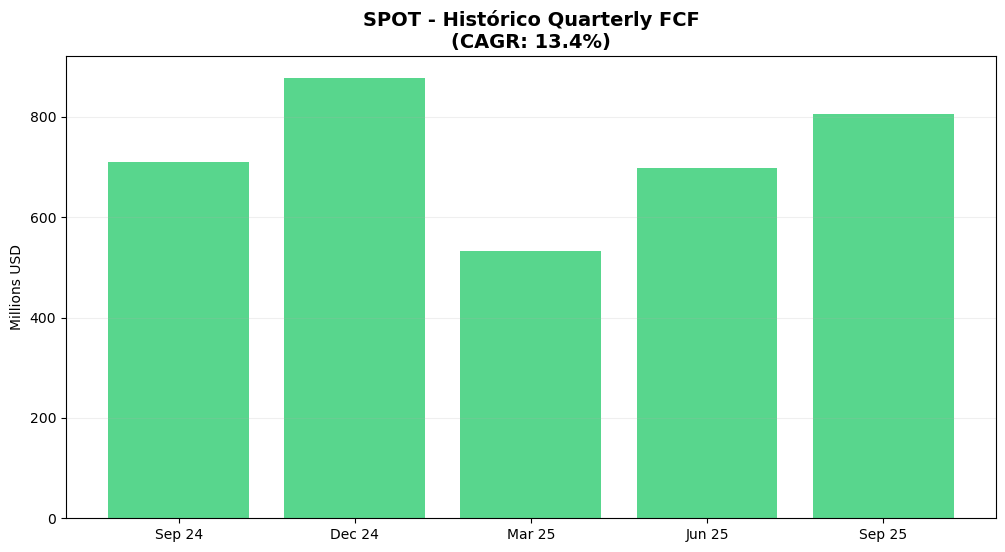


🎲 EJECUTANDO SIMULACIÓN DE MONTE CARLO (n=1000)...
 └─ Volatilidad Trimestral del FCF: 27.6%


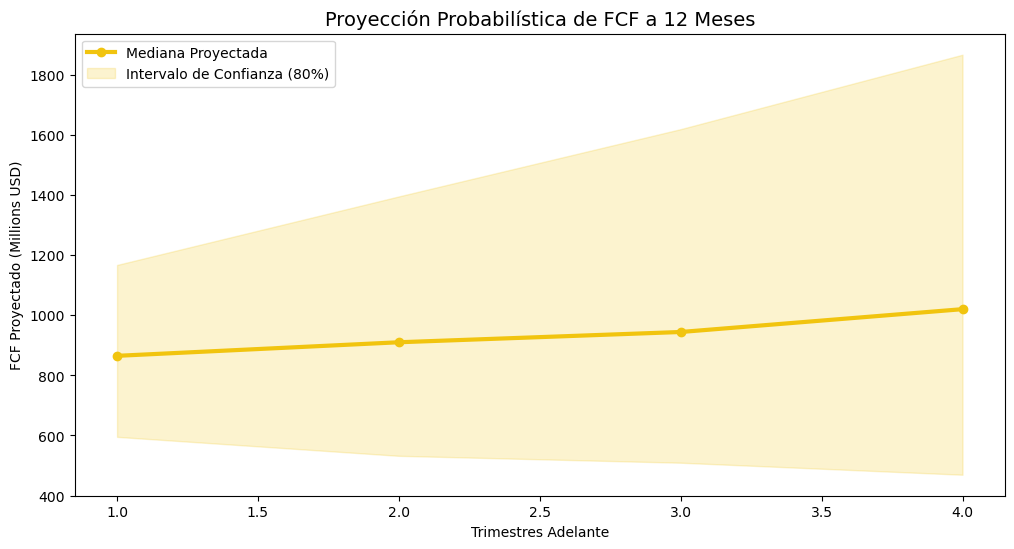


🌡️ GENERANDO MATRIZ DE SENSIBILIDAD (WACC vs Múltiplos)...


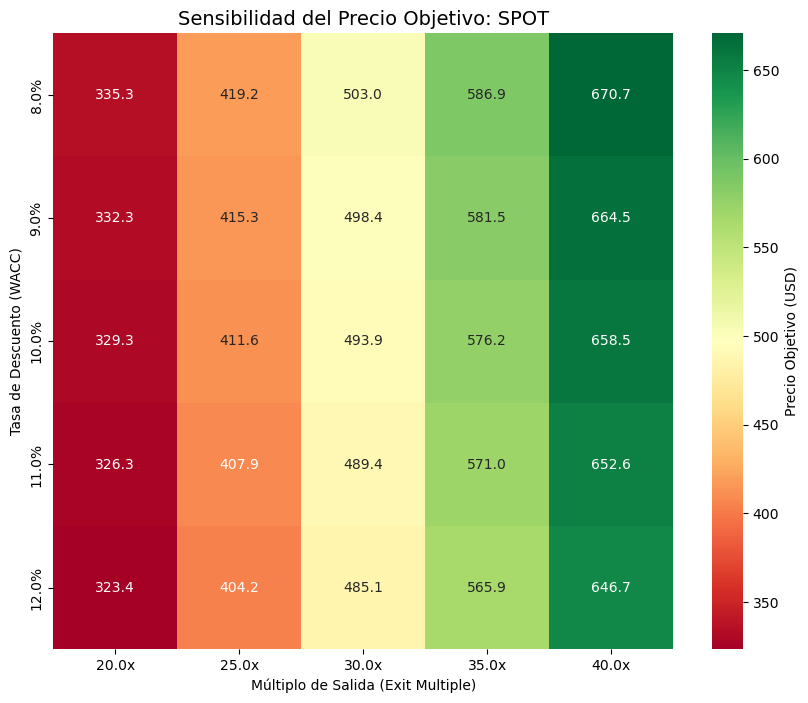

 └─ Precio Actual Mercado: $513.21 USD
 └─ Valor Intrínseco Medio Proyectado: $493.96 USD


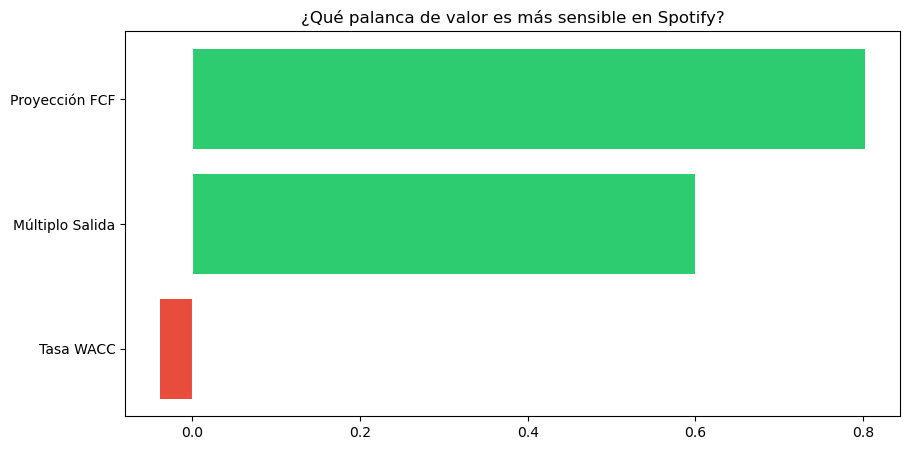


🏁 ANÁLISIS FINALIZADO PARA SPOT



In [7]:
if __name__ == "__main__":
    analyst = QuantmentalProAnalyzer('SPOT')
    analyst.run_full_analysis()

* Proyección FCF: Es la variable más crítica. Al tener la correlación positiva más alta (cercana a 0.8), significa que cualquier pequeña variación en la capacidad de Spotify para generar caja moverá el precio mucho más que las otras variables.

* Múltiplo de Salida: También tiene una correlación positiva considerable. Indica que el sentimiento del mercado (cuánto están dispuestos a pagar por cada dólar de FCF) es el segundo motor de valor más importante.

* Tasa WACC: Tiene una correlación negativa. Esto es teóricamente correcto: si las tasas de interés o el riesgo percibido suben (WACC aumenta), el valor de la empresa baja (efecto descuento). Sin embargo, al ser la barra más corta, sugiere que, en el rango actual, el precio es menos sensible a cambios en las tasas que al crecimiento del negocio mismo.